In [1]:
import sys

sys.path.append('../..') # Add backtester base dir to $PYTHONPATH

In [2]:
%config InlineBackend.figure_format="retina"
%matplotlib inline
import pyfolio as pf
import pandas as pd
import os
import matplotlib.pyplot as plt
import altair as alt

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

/usr/local/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [3]:
from backtester.datahandler import HistoricalOptionsData
from backtester.strategy import Strategy, StrategyLeg
from backtester.option import Type, Direction
from backtester import Backtest
from backtester.statistics import monthly_returns_heatmap, returns_histogram, returns_chart

In [4]:
# Cleaned up data
data = HistoricalOptionsData("allspx/options_data_clean_v2.h5", key="/SPX", where='quotedate >= "2006-12-06" & quotedate <= "2015-08-21"')
schema = data.schema

We run the backtest on the date range above to compare with [this backtest.](http://dtr-trading.blogspot.com/p/spx-straddle-articles.html) We do the comparison with a [short (ATM) straddle](https://www.investopedia.com/terms/s/shortstraddle.asp) 45 DTE. Essentially the strategy consists of selling both a call and a put with (approximately) the same strike and expiration date, profiting if the underlying asset's price does not move very much. 

In [5]:
# Short ATM straddle
short_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 2)

short_straddle.add_legs([leg1, leg2])
# Exit thresholds: we exit if the loss or profit on the investment on an entry is greater than 25%.
short_straddle.exit_thresholds = (0.25, 0.25)

In [6]:
bt = Backtest()
bt.strategy = short_straddle
bt.data = data
bt.stop_if_broke = False

In [7]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:04:21


leg_1                                               \
                contract underlying expiration  type  strike     cost   
0     SXY070120C01350000        SPX 2007-01-20  call  1350.0  -7340.0   
1     SXY070120C01340000        SPX 2007-01-20  call  1340.0  -7810.0   
2     SXY070120C01345000        SPX 2007-01-20  call  1345.0  -7400.0   
3     SXY070120C01355000        SPX 2007-01-20  call  1355.0  -6850.0   
4     SXY070217C01350000        SPX 2007-02-17  call  1350.0  -8080.0   
...                  ...        ...        ...   ...     ...      ...   
1684  SPX150821C01965000        SPX 2015-08-21  call  1965.0  11390.0   
1685  SPX150821C01980000        SPX 2015-08-21  call  1980.0   9890.0   
1686  SPX150821C01985000        SPX 2015-08-21  call  1985.0   9390.0   
1687  SPX150918C02005000        SPX 2015-09-18  call  2005.0   5680.0   
1688  SPX150918C02000000        SPX 2015-09-18  call  2000.0   6030.0   

                              leg_2                                     \
          order            contract underlying expiration type  strike   
0     Order.STO  SXY070120P01350000        SPX 2007-01-20  put  1350.0   
1     Order.STO  SXY070120P01340000        SPX 2007-01-20  put  1340.0   
2     Order.STO  SXY070120P01345000        SPX 2007-01-20  put  1345.0   
3     Order.STO  SXY070120P01355000        SPX 2007-01-20  put  1355.0   
4     Order.STO  SXY070217P01350000        SPX 2007-02-17  put  1350.0   
...         ...                 ...        ...        ...  ...     ...   
1684  Order.BTC  SPX150821P01965000        SPX 2015-08-21  put  1965.0   
1685  Order.BTC  SPX150821P01980000        SPX 2015-08-21  put  1980.0   
1686  Order.BTC  SPX150821P01985000        SPX 2015-08-21  put  1985.0   
1687  Order.BTC  SPX150918P02005000        SPX 2015-09-18  put  2005.0   
1688  Order.BTC  SPX150918P02000000        SPX 2015-09-18  put  2000.0   

                          totals                    
        cost      order     cost    qty       date  
0     -420.0  Order.STO  -7760.0  129.0 2006-12-06  
1     -480.0  Order.STO  -8290.0  121.0 2006-12-07  
2     -460.0  Order.STO  -7860.0  128.0 2006-12-08  
3     -440.0  Order.STO  -7290.0  138.0 2006-12-11  
4     -560.0  Order.STO  -8640.0  116.0 2006-12-29  
...      ...        ...      ...    ...        ...  
1684    20.0  Order.BTC  11410.0   74.0 2015-08-19  
1685    20.0  Order.BTC   9910.0   78.0 2015-08-19  
1686    25.0  Order.BTC   9415.0   83.0 2015-08-19  
1687  3130.0  Order.BTC   8810.0   83.0 2015-08-20  
1688  3010.0  Order.BTC   9040.0   83.0 2015-08-20  

[1689 rows x 17 columns]

In [8]:
bt.summary()

,Strategy
Total trades,842
Number of wins,400
Number of losses,442
Win %,47.51%
Largest loss,$528640.00
Profit factor,0.90
Average profit,$-7624.90
Average P&L %,-3.99%
Total P&L %,302.89%


/usr/local/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:445: RuntimeWarning: invalid value encountered in double_scalars
  return ending_value ** (1 / num_years) - 1
/usr/local/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:1492: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2006-12-06
End date,2015-08-21
Total months,104
,Backtest
Annual return,nan%
Cumulative returns,-243.9%
Annual volatility,3995.6%
Sharpe ratio,-0.25
Calmar ratio,NaN
Stability,NaN
Max drawdown,-342.0%


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,341.99,2007-01-05,2007-05-18,2007-11-19,227
1,139.82,2011-12-19,2014-04-02,NaT,NaN
2,60.76,2007-12-04,2007-12-10,2007-12-14,9
3,59.22,2006-12-07,2006-12-14,2006-12-22,12
4,52.66,2006-12-22,2006-12-27,2007-01-05,11


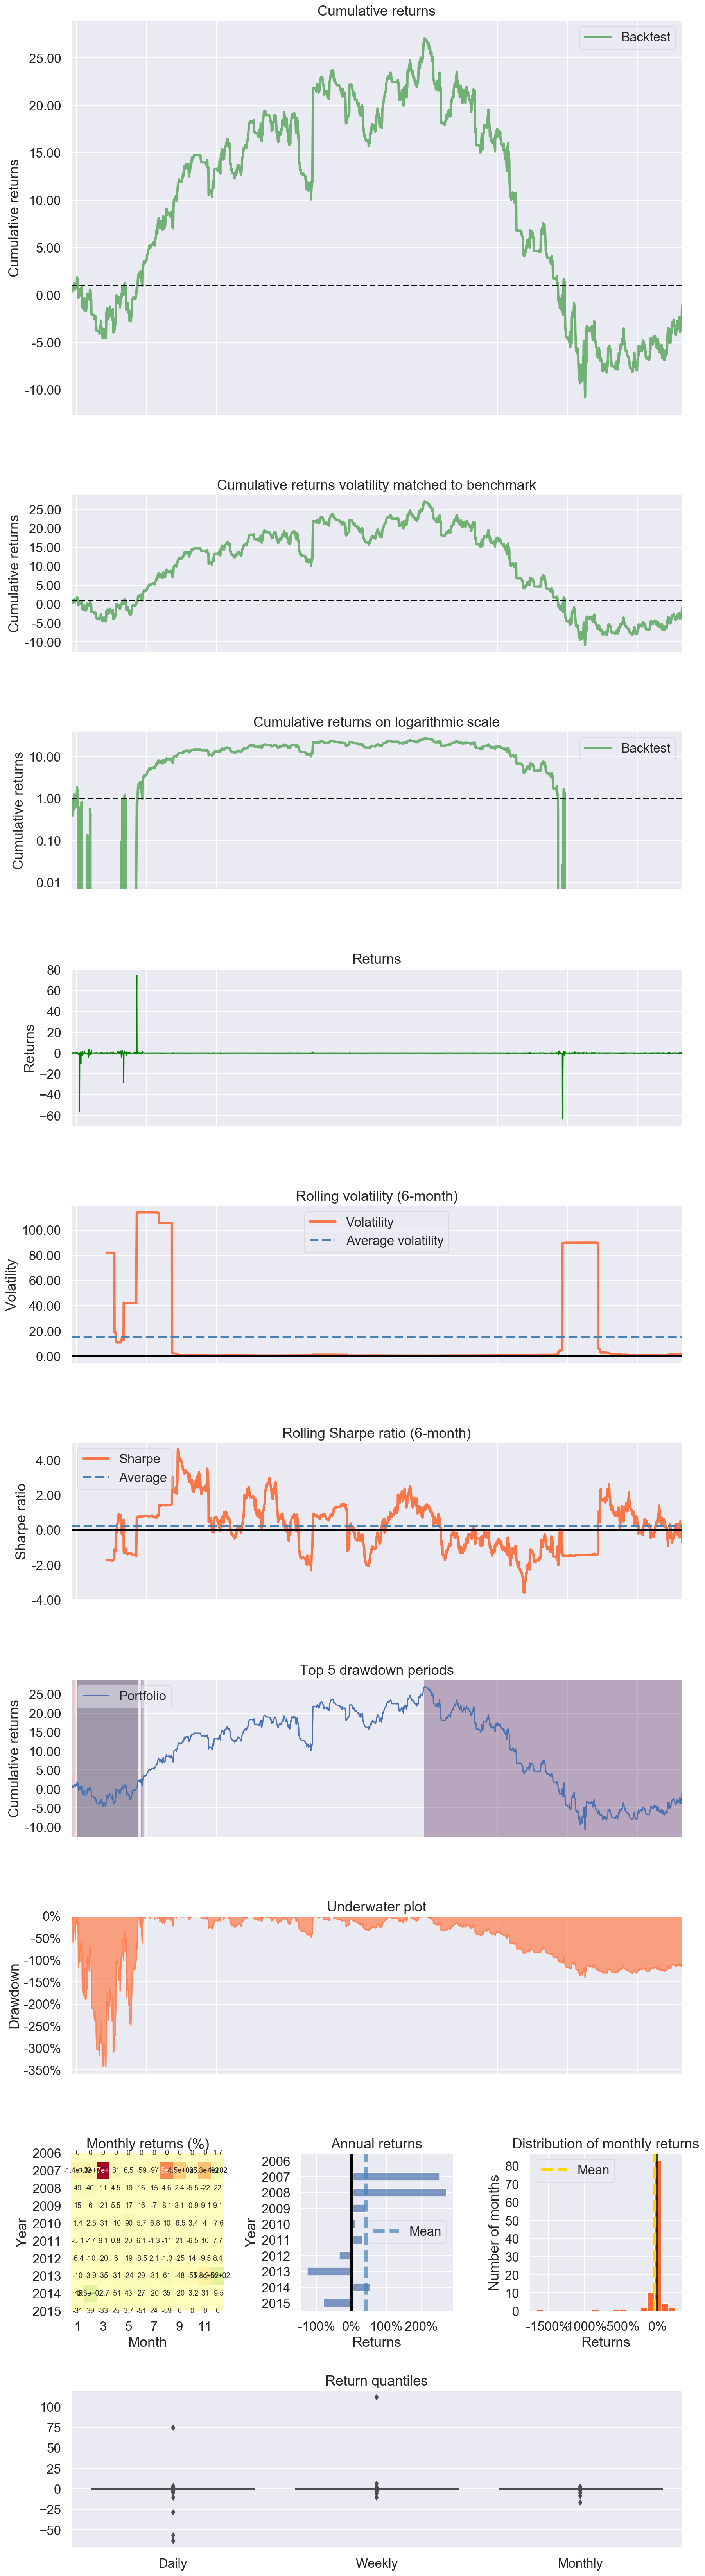

In [9]:
pf.create_returns_tear_sheet(returns = bt.balance['% change'].dropna())